In [1]:
from surprise import SVD

In [2]:
import pandas as pd
import numpy as np
import surprise

In [3]:
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV

### Question 3(a)

In [4]:
df = pd.read_csv('ratings_small.csv')
df

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


### Question 3(c) and 3(d)

In [6]:
# Source: https://www.kaggle.com/code/robottums/probabalistic-matrix-factorization-with-suprise


class ProbabilisticMatrixFactorization(surprise.AlgoBase):
# Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean

In [7]:
reader = surprise.Reader(rating_scale=(1,5)) 

In [8]:
#swapping columns
data = surprise.Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [9]:
### PMF
algo = ProbabilisticMatrixFactorization(learning_rate=0.05,num_epochs=5,num_factors=10)

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

C:\Users\md805971\AppData\Local\Temp\ipykernel_10196\2918731268.py:22: RuntimeWarning: overflow encountered in multiply
  Q[i,:] +=  self.alpha * residual * temp
C:\Users\md805971\AppData\Local\Temp\ipykernel_10196\2918731268.py:21: RuntimeWarning: overflow encountered in multiply
  P[u,:] +=  self.alpha * residual * Q[i]


Evaluating RMSE, MAE of algorithm ProbabilisticMatrixFactorization on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0499  1.0590  1.0594  1.0620  1.0609  1.0582  0.0043  
MAE (testset)     0.8080  0.8515  0.8516  0.8513  0.8209  0.8366  0.0186  
Fit time          1.41    1.38    1.41    1.39    1.39    1.39    0.01    
Test time         0.09    0.08    0.11    0.08    0.12    0.10    0.02    


{'test_rmse': array([1.04991545, 1.05899269, 1.0593616 , 1.06197123, 1.06085641]),
 'test_mae': array([0.80801031, 0.85150755, 0.85158963, 0.8512545 , 0.82087844]),
 'fit_time': (1.4061360359191895,
  1.3774466514587402,
  1.405146598815918,
  1.3903343677520752,
  1.3882174491882324),
 'test_time': (0.09374022483825684,
  0.07788562774658203,
  0.10936164855957031,
  0.08064651489257812,
  0.12498736381530762)}

In [10]:
### User-Based Collaborative Filtering

sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute  similarities between users
}

algo1 = KNNWithMeans(sim_options=sim_options)

cross_validate(algo1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9290  0.9231  0.9145  0.9240  0.9187  0.9219  0.0049  
MAE (testset)     0.7135  0.7068  0.7024  0.7081  0.7038  0.7069  0.0038  
Fit time          0.17    0.18    0.19    0.17    0.18    0.18    0.01    
Test time         0.73    0.78    0.80    0.75    0.74    0.76    0.02    


{'test_rmse': array([0.92900306, 0.92305984, 0.91454694, 0.9239592 , 0.91871502]),
 'test_mae': array([0.71346176, 0.70678565, 0.70243505, 0.70812429, 0.70384615]),
 'fit_time': (0.17179036140441895,
  0.18005633354187012,
  0.18753409385681152,
  0.17206168174743652,
  0.1784343719482422),
 'test_time': (0.734379768371582,
  0.7810800075531006,
  0.7968268394470215,
  0.7498495578765869,
  0.7434616088867188)}

In [11]:
### Item-Based Collaborative Filtering

sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}

algo2 = KNNWithMeans(sim_options=sim_options)

cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9243  0.9350  0.9292  0.9179  0.9248  0.9262  0.0057  
MAE (testset)     0.7081  0.7155  0.7122  0.7035  0.7078  0.7094  0.0041  
Fit time          2.41    2.28    2.36    2.29    2.39    2.35    0.05    
Test time         2.61    2.39    2.48    2.70    2.56    2.55    0.11    


{'test_rmse': array([0.92427042, 0.93501289, 0.92918862, 0.9178891 , 0.9248182 ]),
 'test_mae': array([0.7081391 , 0.71551805, 0.71217968, 0.70345732, 0.7077752 ]),
 'fit_time': (2.4096875190734863,
  2.2752742767333984,
  2.3591103553771973,
  2.2914249897003174,
  2.3922979831695557),
 'test_time': (2.613089084625244,
  2.390836715698242,
  2.478663206100464,
  2.703416109085083,
  2.5604753494262695)}

### Question 3(e)

In [12]:
### User-Based Collaborative Filtering with MSD

sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}

algo1 = KNNWithMeans(sim_options=sim_options)

cross_validate(algo1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9210  0.9182  0.9213  0.9277  0.9089  0.9194  0.0061  
MAE (testset)     0.7046  0.7047  0.7022  0.7101  0.6969  0.7037  0.0043  
Fit time          0.09    0.09    0.09    0.09    0.09    0.09    0.00    
Test time         0.70    0.66    0.67    0.69    0.64    0.67    0.02    


{'test_rmse': array([0.92102263, 0.91820021, 0.92132902, 0.92770679, 0.90892638]),
 'test_mae': array([0.70456354, 0.70473153, 0.7021561 , 0.71014293, 0.69694501]),
 'fit_time': (0.09372067451477051,
  0.09375882148742676,
  0.09175515174865723,
  0.09375166893005371,
  0.09372425079345703),
 'test_time': (0.7011761665344238,
  0.6577281951904297,
  0.6716904640197754,
  0.6874315738677979,
  0.6407313346862793)}

In [13]:
### Item-Based Collaborative Filtering with MSD

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between items
}

algo2 = KNNWithMeans(sim_options=sim_options)

cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9097  0.9116  0.9077  0.9188  0.9163  0.9128  0.0041  
MAE (testset)     0.6955  0.6979  0.6966  0.7028  0.7016  0.6989  0.0028  
Fit time          1.42    1.36    1.41    1.33    1.41    1.39    0.04    
Test time         2.58    2.53    2.63    2.52    2.75    2.60    0.08    


{'test_rmse': array([0.90971131, 0.91159236, 0.90765785, 0.91881215, 0.91629035]),
 'test_mae': array([0.69553648, 0.69788824, 0.69661677, 0.70284278, 0.70155057]),
 'fit_time': (1.4246127605438232,
  1.3594894409179688,
  1.4132182598114014,
  1.328502893447876,
  1.4138381481170654),
 'test_time': (2.5754261016845703,
  2.5314013957977295,
  2.6336798667907715,
  2.5151772499084473,
  2.7491354942321777)}

In [14]:
### User-Based Collaborative Filtering with pearson

sim_options = {
    "name": "pearson",
    "user_based": True,  # Compute  similarities between users
}

algo1 = KNNWithMeans(sim_options=sim_options)

cross_validate(algo1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9160  0.9269  0.9247  0.9213  0.9270  0.9232  0.0041  
MAE (testset)     0.7008  0.7054  0.7053  0.7013  0.7068  0.7039  0.0024  
Fit time          0.19    0.17    0.18    0.19    0.17    0.18    0.01    
Test time         0.70    0.64    0.62    0.69    0.62    0.65    0.03    


{'test_rmse': array([0.91602486, 0.92685183, 0.92474894, 0.92134903, 0.92699908]),
 'test_mae': array([0.70077041, 0.70539879, 0.70525034, 0.70132254, 0.70679215]),
 'fit_time': (0.18754196166992188,
  0.17349982261657715,
  0.1815929412841797,
  0.1890852451324463,
  0.17135906219482422),
 'test_time': (0.7031946182250977,
  0.6390323638916016,
  0.6169381141662598,
  0.6883430480957031,
  0.6248292922973633)}

In [15]:
### Item-Based Collaborative Filtering with Pearson

sim_options = {
    "name": "pearson",
    "user_based": False,  # Compute  similarities between items
}

algo2 = KNNWithMeans(sim_options=sim_options)

cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9290  0.9325  0.9286  0.9313  0.9290  0.9301  0.0015  
MAE (testset)     0.7107  0.7083  0.7074  0.7064  0.7089  0.7083  0.0014  
Fit time          3.15    3.13    3.22    3.14    3.16    3.16    0.03    
Test time         2.59    2.42    2.43    2.56    2.65    2.53    0.09    


{'test_rmse': array([0.92902952, 0.93250257, 0.92862656, 0.93130946, 0.92902766]),
 'test_mae': array([0.71065159, 0.70831179, 0.70739555, 0.70644369, 0.70894013]),
 'fit_time': (3.145470142364502,
  3.133187770843506,
  3.2233126163482666,
  3.1448872089385986,
  3.1560821533203125),
 'test_time': (2.5891060829162598,
  2.4190447330474854,
  2.4330081939697266,
  2.561420440673828,
  2.6517956256866455)}

### Plotting

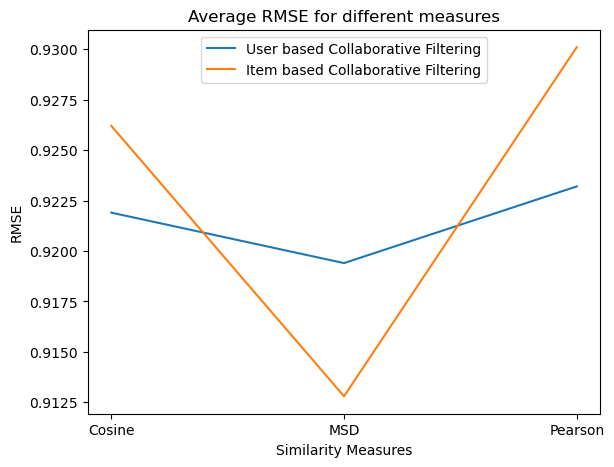

In [40]:
## RMSE
import matplotlib.pyplot as plt
User = [0.9219, 0.9194, 0.9232]
Item = [0.9262, 0.9128, 0.9301]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(User)
ax.plot(Item)

ax.set_title('Average RMSE for different measures')
ax.set_xlabel('Similarity Measures')
ax.set_ylabel('RMSE')

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Cosine','MSD','Pearson'])
ax.legend(["User based Collaborative Filtering", "Item based Collaborative Filtering"], loc='upper center')

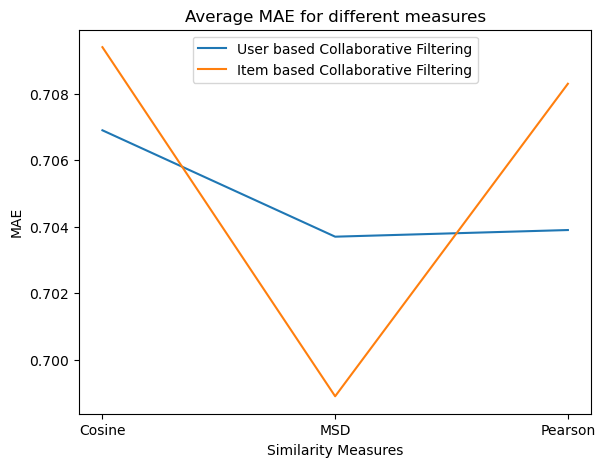

In [39]:
## MAE
import matplotlib.pyplot as plt
User = [0.7069, 0.7037, 0.7039]
Item = [0.7094, 0.6989, 0.7083]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(User)
ax.plot(Item)

ax.set_title('Average MAE for different measures')
ax.set_xlabel('Similarity Measures')
ax.set_ylabel('MAE')

ax.set_xticks([0,1,2])
ax.set_xticklabels(['Cosine','MSD','Pearson'])
ax.legend(["User based Collaborative Filtering", "Item based Collaborative Filtering"], loc='upper center')

## Question 3(f)

### First, let's check which similarity measure is performing well for both User based and Item based C.F.

In [41]:
## With different K 

## User based

sim_options = {
    "name": ["cosine", "msd", "pearson"],
    "user_based": [True]
}

param_grid = {"sim_options": sim_options, "k": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=5)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [42]:
print(gs.best_params["rmse"])
print(gs.best_score["rmse"])

{'sim_options': {'name': 'msd', 'user_based': True}, 'k': 45}
0.9186834439352844


In [44]:
## Item based

sim_options = {
    "name": ["cosine", "msd", "pearson"],
    "user_based": [False]
}

param_grid = {"sim_options": sim_options, "k": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=5)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [45]:
print(gs.best_params["rmse"])
print(gs.best_score["rmse"])

{'sim_options': {'name': 'msd', 'user_based': False}, 'k': 50}
0.9116842698767377


### As expected, MSD outperforms other two similarity measures. We will measure the model performance using MSD measure

In [46]:
### User-Based

sim_options = {
    "name": "msd",
    "user_based": True,  
}

for k in [10, 20, 30, 40, 50, 100, 150, 200]:
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9231  0.9300  0.9277  0.9385  0.9300  0.9299  0.0050  
Fit time          0.09    0.09    0.09    0.10    0.10    0.10    0.00    
Test time         0.48    0.55    0.63    0.46    0.44    0.51    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simi

In [47]:
### Item-Based

sim_options = {
    "name": "msd",
    "user_based": False,  
}

for k in [10, 20, 30, 40, 50, 100, 150, 200]:
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9424  0.9462  0.9492  0.9446  0.9358  0.9436  0.0045  
Fit time          1.40    1.62    1.39    1.33    1.38    1.42    0.10    
Test time         1.98    1.87    1.98    1.94    1.92    1.94    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simi

### Plotting

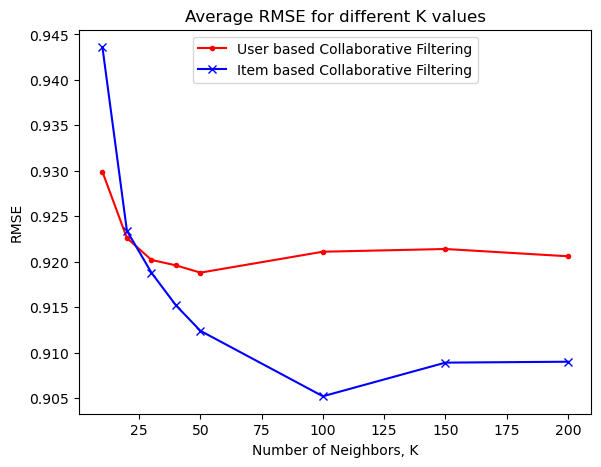

In [52]:
## RMSE
import matplotlib.pyplot as plt
User = [0.9299, 0.9226, 0.9202, 0.9196, 0.9188, 0.9211, 0.9214, 0.9206]
Item = [0.9436, 0.9234, 0.9188, 0.9152, 0.9124, 0.9052, 0.9089, 0.9090]
K = [10, 20, 30, 40, 50, 100, 150, 200]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(K, User,'.r-')
ax.plot(K, Item, 'xb-')

ax.set_title('Average RMSE for different K values')
ax.set_xlabel('Number of Neighbors, K')
ax.set_ylabel('RMSE')

ax.legend(["User based Collaborative Filtering", "Item based Collaborative Filtering"], loc='upper center')

### Question 3(g)

#### Finding optimum neighbours

In [53]:
### User-Based

sim_options = {
    "name": "msd",
    "user_based": True,  # Compute  similarities between users
}

for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
          110, 120, 130, 140, 150, 160, 170, 180, 190, 200]:
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
    print("\n")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9550  0.9580  0.9609  0.9624  0.9569  0.9586  0.0027  
Fit time          0.09    0.09    0.09    0.09    0.10    0.09    0.00    
Test time         0.41    0.58    0.42    0.39    0.41    0.44    0.07    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing si

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9130  0.9152  0.9228  0.9295  0.9178  0.9197  0.0059  
Fit time          0.09    0.09    0.09    0.09    0.09    0.09    0.00    
Test time         0.92    0.72    0.69    0.72    0.83    0.77    0.09    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std  

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9158  0.9281  0.9236  0.9227  0.9120  0.9205  0.0058  
Fit time          0.10    0.09    0.09    0.09    0.09    0.10    0.00    
Test time         0.74    0.86    0.78    0.77    0.75    0.78    0.04    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing si

In [54]:
### Item-Based

sim_options = {
    "name": "msd",
    "user_based": False,  # Compute  similarities between users
}

for k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100,
          110, 120, 130, 140, 150, 160, 170, 180, 190, 200]:
    algo = KNNWithMeans(sim_options=sim_options, k = k)
    cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
    print("\n")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9698  0.9734  0.9748  0.9841  0.9747  0.9754  0.0047  
Fit time          1.36    1.39    1.45    1.39    1.38    1.39    0.03    
Test time         2.14    1.87    2.05    1.91    2.08    2.01    0.10    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing si

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9076  0.9086  0.9152  0.9143  0.9082  0.9108  0.0033  
Fit time          1.34    1.55    1.35    1.42    1.41    1.41    0.07    
Test time         2.97    2.78    2.86    3.00    3.03    2.93    0.09    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std  

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9186  0.9066  0.9103  0.9103  0.9172  0.9126  0.0045  
Fit time          1.33    1.36    1.39    1.36    1.36    1.36    0.02    
Test time         3.88    3.78    3.67    3.62    3.84    3.76    0.10    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd simi

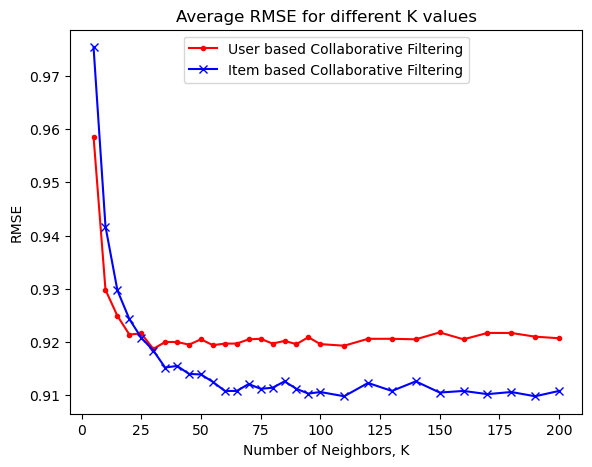

In [55]:
## RMSE
import matplotlib.pyplot as plt
User = [0.9586, 0.9298, 0.9249, 0.9214, 0.9216, 0.9187, 0.92, 0.92, 0.9195, 0.9205, 0.9194, 0.9197, 0.9197, 0.9205, 
        0.9206, 0.9197, 0.9202, 0.9196, 0.9209, 0.9196, 0.9193, 0.9206, 0.9206, 0.9205, 0.9218, 0.9205, 0.9217, 0.9217,
        0.9210, 0.9207] 

Item = [0.9754, 0.9417, 0.9297, 0.9243, 0.9208, 0.9184, 0.9152, 0.9155, 0.9140, 0.9139, 0.9125, 0.9108, 0.9108, 0.9121, 
        0.9112,0.9114, 0.9126, 0.9112, 0.9103, 0.9106, 0.9098, 0.9123, 0.9108, 0.9126, 0.9105, 0.9108, 0.9102, 0.9106, 
        0.9098, 0.9108]

K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 
     90, 95, 100,110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax.plot(K, User,'.r-')
ax.plot(K, Item, 'xb-')

ax.set_title('Average RMSE for different K values')
ax.set_xlabel('Number of Neighbors, K')
ax.set_ylabel('RMSE')

ax.legend(["User based Collaborative Filtering", "Item based Collaborative Filtering"], loc='upper center')